In [45]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,recall_score,precision_score
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import KFold
from joblib import dump, load
from sklearn.model_selection import cross_val_score
from mrmr import mrmr_classif
from collections import Counter
import  matplotlib.pyplot as plt
import seaborn as sns

In [46]:
def get_results(acc_list,auc_list,recall_list,precision_list):    
    acc_list = np.array(acc_list)
    auc_list = np.array(auc_list)
    recall_list = np.array(recall_list)
    precision_list = np.array(precision_list)
    print(f'Recall, Average:{recall_list.mean():.4f}, Std:{recall_list.std():.4f}')
    print(f'precision, Average:{precision_list.mean():.4f}, Std:{precision_list.std():.4f}')
    print(f'Accuracy, Average:{acc_list.mean():.4f}, Std:{acc_list.std():.4f}')
    print(f'AUC, Average:{auc_list.mean():.4f}, Std:{auc_list.std():.4f}')
    return auc_list.mean()

In [47]:
def features_selection(features_corr):
    occor_list = []
    for feature in features_corr.columns:
        selected_features = features_corr[feature][abs(features_corr[feature]) < 0.2].index.tolist()
        occor_list.extend(selected_features)
    return pd.DataFrame(occor_list)

In [48]:
features = pd.read_csv('./diabetes_radiomics_features.csv')
features = pd.concat([features.iloc[:,0],features.iloc[:,23:]],axis=1)

features_type = {'shape':[],'firstorder':[],'glcm':[],'gldm':[],'glrlm':[],'glszm':[],'ngtdm':[]}
for f_type in features_type:
    for col_name in features.columns:
        if f_type in col_name:  
            features_type[f_type].append(col_name)

Select first

In [49]:
features_corr = features.drop(columns=['Image']).corr()
occr_df = features_selection(features_corr)

In [50]:
counts = occr_df.value_counts()
result = counts[counts > 60].index.tolist()
features_name = [num[0] for num in result]


In [51]:
drop_list = ['original_glrlm_HighGrayLevelRunEmphasis', 'original_glszm_HighGrayLevelZoneEmphasis',
             'original_firstorder_TotalEnergy','original_shape_SurfaceArea','original_glcm_Correlation',
             'original_glrlm_RunEntropy','original_shape_MajorAxisLength', 'original_shape_SurfaceVolumeRatio']
for to_drop in drop_list:
    features_name.remove(to_drop)

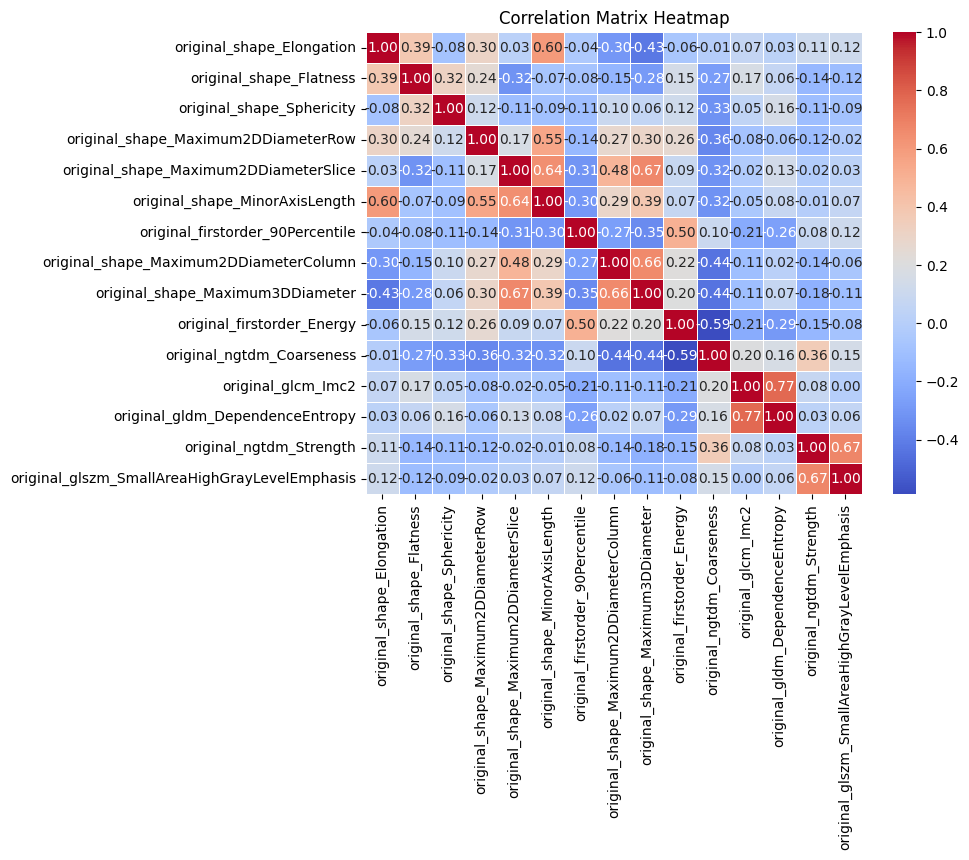

In [52]:
corr = features[features_name].corr()
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title("Correlation Matrix Heatmap")
plt.show()

In [53]:
# selected_features = features[features_name+['Image']]
selected_features = features

In [54]:
label = pd.read_csv('./panc_isim.csv')
label["Image"] = label['Image'].apply(lambda x: str(x)+'.nii.gz')
label = label.drop(columns=['patient'])
data = pd.merge(selected_features,label,on='Image',how="left")

In [55]:
data

,Image,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Label
0,1.nii.gz,0.412880,0.237328,40.595908,171.053711,167.546158,110.152844,109.862332,175.719590,177713.515413,...,0.008021,5.547142,0.056526,5.141753e+05,90.449013,0.000039,143.732475,0.018153,0.006372,1
1,10.nii.gz,0.416632,0.277899,40.573705,146.001854,141.609105,92.331688,101.679808,146.554589,131120.681763,...,0.009268,5.529802,0.018985,2.084244e+06,107.629268,0.000060,37.124029,0.007548,0.006089,1
2,100.nii.gz,0.452984,0.265741,52.613793,197.988666,161.541237,128.011123,149.655659,188.547449,246240.573486,...,0.011384,5.600006,0.053184,9.859233e+05,230.606804,0.000021,113.206175,0.022049,0.002344,0
3,101.nii.gz,0.359082,0.263969,47.336194,179.325101,137.814613,68.909368,155.087679,169.938363,235562.382359,...,0.012892,5.040934,0.046406,1.539011e+06,112.555532,0.000026,186.320002,0.003839,0.015610,0
4,102.nii.gz,0.437294,0.257919,38.730194,150.164423,101.926742,88.360937,107.392101,149.632375,95453.745494,...,0.000764,6.291685,0.027106,6.394617e+05,5.978181,0.000108,301.497228,0.005743,0.182172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,95.nii.gz,0.316838,0.269693,44.977131,166.771695,110.179616,75.098432,102.406366,174.738438,93251.407608,...,0.011892,6.193459,0.020123,1.125833e+06,57.228898,0.000097,48.816494,0.012078,0.011009,0
135,96.nii.gz,0.521553,0.308605,37.137142,120.338650,87.807211,81.146451,100.781396,120.246021,68892.763726,...,0.026730,6.165693,0.033858,2.627858e+05,59.533499,0.000142,51.673933,0.031325,0.008845,0
136,97.nii.gz,0.573334,0.367684,41.238771,112.158334,114.675152,77.597544,102.509141,115.616251,78209.574782,...,0.009032,5.921340,0.044263,3.571305e+05,42.298562,0.000089,104.190364,0.017464,0.013868,0
137,98.nii.gz,0.350989,0.186391,26.265160,140.914083,92.669023,68.081348,63.979794,127.166893,39577.700233,...,0.031022,5.817202,0.022543,3.264400e+05,60.250625,0.000203,23.400857,0.016724,0.008718,0


Read fold data

In [56]:
import json
with open('./Trial_1.json', "r") as file:
    fold_data = json.load(file)
    
data_train = data[data["Image"].isin(fold_data['train'])]
data_test = data[data["Image"].isin(fold_data['test'])]

In [57]:

X_train = data_train.drop(columns=['Image','Label'])
y_train = data_train[["Label"]]

X_test = data_test.drop(columns=['Image','Label'])
y_test = data_test[["Label"]]

standard_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(standard_scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(standard_scaler.transform(X_test),columns=X_test.columns)

param_grid = {
    'n_estimators': [140,150,160,170],          
    'max_depth': [4,5,6,8,10],            
    'min_samples_split': [2],         
    'min_samples_leaf': [7,8,9],           
    'max_features': [7,8,9,10],  
    'bootstrap': [True]               
} 

# GridSearchCV get bset hyper parameters
rf_model = RandomForestClassifier(random_state=3)
grid_search = GridSearchCV(
    estimator=rf_model,           # 目标模型
    param_grid=param_grid,        # 参数网格
    cv=5,                         # 5折交叉验证
    scoring='roc_auc',           # 评分标准（可以选择'accuracy', 'f1'等）
    n_jobs=-1,                    # 使用所有可用内核
    verbose=1                     # 输出搜索过程
)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=3), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 5, 6, 8, 10],
                         'max_features': [7, 8, 9, 10],
                         'min_samples_leaf': [7, 8, 9],
                         'min_samples_split': [2],
                         'n_estimators': [140, 150, 160, 170]},
             scoring='roc_auc', verbose=1)

In [58]:
results = grid_search.cv_results_
for i in range(len(results['params'])):
    print(f"Search {i + 1}: {results['params'][i]}")
    mean_test_auc = results['mean_test_score'][i]
    print(f"Average AUC: {mean_test_auc:.4f}")
    for fold in range(grid_search.cv):
        # fold_test_accuracy = results[f'split{fold}_test_score'][i]
        fold_test_auc = results[f'split{fold}_test_score'][i]
        print(f"  Fold {fold + 1} - , validation AUC: {fold_test_auc:.4f}")
    print("-" * 40)

Search 1: {'bootstrap': True, 'max_depth': 4, 'max_features': 7, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 140}
Average AUC: 0.4893
  Fold 1 - , validation AUC: 0.3314
  Fold 2 - , validation AUC: 0.3718
  Fold 3 - , validation AUC: 0.5897
  Fold 4 - , validation AUC: 0.5641
  Fold 5 - , validation AUC: 0.5897
----------------------------------------
Search 2: {'bootstrap': True, 'max_depth': 4, 'max_features': 7, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 150}
Average AUC: 0.4842
  Fold 1 - , validation AUC: 0.3314
  Fold 2 - , validation AUC: 0.3782
  Fold 3 - , validation AUC: 0.5641
  Fold 4 - , validation AUC: 0.5641
  Fold 5 - , validation AUC: 0.5833
----------------------------------------
Search 3: {'bootstrap': True, 'max_depth': 4, 'max_features': 7, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 160}
Average AUC: 0.4841
  Fold 1 - , validation AUC: 0.3373
  Fold 2 - , validation AUC: 0.3654
  Fold 3 - , validation AUC

Test Set

In [59]:
models = []
test_acc_list = []
test_auc_list = []
test_recall_list = []
test_precision_list = []
val_acc_list = []
val_auc_list = []
val_recall_list = []
val_precision_list = []

kf = KFold(n_splits=5, shuffle=True, random_state=5)
for fold,(train_idx, val_idx) in enumerate(kf.split(X_train_scaled, y_train)):
    X_train_f, X_val_f = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_train_f, y_val_f = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Get best hyper params
    best_params = grid_search.best_params_
    best_rf_model = RandomForestClassifier(**best_params, random_state=42)
    best_rf_model.fit(X_train_f, y_train_f)
    # Save model
    models.append(best_rf_model)
    
    fold_accuracy = accuracy_score(y_val_f, best_rf_model.predict(X_val_f))
    val_acc_list.append(fold_accuracy)
    fold_auc = roc_auc_score(y_val_f, best_rf_model.predict_proba(X_val_f)[:, 1])
    val_auc_list.append(fold_auc)
    print(f"Fold {fold + 1} - ACC: {fold_accuracy:.4f}, AUC: {fold_auc:.4f}")
    test_accuracy = accuracy_score(y_test, best_rf_model.predict(X_test))
    test_acc_list.append(test_accuracy)
    test_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
    test_auc_list.append(test_auc)
    print(f"Test {fold + 1} - ACC: {test_accuracy:.4f}, AUC: {test_auc:.4f}")
    print("-" * 40)

print('Validation set')
get_results(val_acc_list,val_auc_list,val_recall_list,val_precision_list)
print("Test set")
get_results(test_acc_list,test_auc_list,test_recall_list,test_precision_list)
print('================================================')


Fold 1 - ACC: 0.4615, AUC: 0.5774
Test 1 - ACC: 0.3846, AUC: 0.5250
----------------------------------------
Fold 2 - ACC: 0.4800, AUC: 0.4156
Test 2 - ACC: 0.3846, AUC: 0.3500
----------------------------------------
Fold 3 - ACC: 0.5200, AUC: 0.6067
Test 3 - ACC: 0.3846, AUC: 0.3125
----------------------------------------
Fold 4 - ACC: 0.6400, AUC: 0.5833
Test 4 - ACC: 0.3846, AUC: 0.5875
----------------------------------------
Fold 5 - ACC: 0.5200, AUC: 0.4667
Test 5 - ACC: 0.3846, AUC: 0.7375
----------------------------------------
Validation set
Recall, Average:nan, Std:nan
precision, Average:nan, Std:nan
Accuracy, Average:0.5243, Std:0.0622
AUC, Average:0.5299, Std:0.0749
Test set
Recall, Average:nan, Std:nan
precision, Average:nan, Std:nan
Accuracy, Average:0.3846, Std:0.0000
AUC, Average:0.5025, Std:0.1564
